In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/aptos2019-blindness-detection/sample_submission.csv
/kaggle/input/aptos2019-blindness-detection/train.csv
/kaggle/input/aptos2019-blindness-detection/test.csv
/kaggle/input/aptos2019-blindness-detection/train_images/ef476be214d4.png
/kaggle/input/aptos2019-blindness-detection/train_images/6dcde47060f9.png
/kaggle/input/aptos2019-blindness-detection/train_images/ec363f48867b.png
/kaggle/input/aptos2019-blindness-detection/train_images/17f6c7072f61.png
/kaggle/input/aptos2019-blindness-detection/train_images/b49b2fac2514.png
/kaggle/input/aptos2019-blindness-detection/train_images/af6166d57f13.png
/kaggle/input/aptos2019-blindness-detection/train_images/8d13c46e7d75.png
/kaggle/input/aptos2019-blindness-detection/train_images/c3b15bf9b4bc.png
/kaggle/input/aptos2019-blindness-detection/train_images/be68322c7223.png
/kaggle/input/aptos2019-blindness-detection/train_images/88e4399d207c.png
/kaggle/input/aptos2019-blindness-detection/train_images/0243404e8a00.png
/kaggle/input

In [4]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Define paths and constants
DATA_DIR = '/kaggle/input/aptos2019-blindness-detection/'
TRAIN_CSV = os.path.join(DATA_DIR, 'train.csv')
TEST_CSV = os.path.join(DATA_DIR, 'test.csv')
TRAIN_DIR = os.path.join(DATA_DIR, 'train_images')
TEST_DIR = os.path.join(DATA_DIR, 'test_images')

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
N_CLASSES = 5

# Load and prepare DataFrame
df_train = pd.read_csv(TRAIN_CSV)
df_train['id_code'] = df_train['id_code'].apply(lambda x: f'{x}.png')
df_train['diagnosis'] = df_train['diagnosis'].astype(str)

# Stratified split for balanced training/validation sets
train_df, val_df = train_test_split(
    df_train,
    test_size=0.15,
    random_state=42,
    stratify=df_train['diagnosis']
)

# Create data generators with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255, # Normalize pixel values
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=TRAIN_DIR,
    x_col='id_code',
    y_col='diagnosis',
    target_size=IMG_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=TRAIN_DIR,
    x_col='id_code',
    y_col='diagnosis',
    target_size=IMG_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 3112 validated image filenames belonging to 5 classes.
Found 550 validated image filenames belonging to 5 classes.


In [5]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

# 1. Build the base model and custom head
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)
base_model.trainable = False # Freeze base layers initially

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(N_CLASSES, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 2. Define fine-tuning configuration
# Unfreeze the top layers of the base model
# This allows the model to learn more specific features
base_model.trainable = True
for layer in base_model.layers[:-40]: # Unfreeze the last ~40 layers
    layer.trainable = False

# Recompile with a very low learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=0.00001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 25,691,013 (98.00 MB)

 Trainable params: 17,935,109 (68.42 MB)

 Non-trainable params: 7,755,904 (29.59 MB)

Training new classification layers...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.5016 - loss: 1.2738
Epoch 1: val_accuracy improved from -inf to 0.49816, saving model to best_model.weights.h5
97/97 ━━━━━━━━━━━━━━━━━━━━ 884s 9s/step - accuracy: 0.5022 - loss: 1.2727 - val_accuracy: 0.4982 - val_loss: 1.3741
Epoch 2/10
 1/97 ━━━━━━━━━━━━━━━━━━━━ 7:19 5s/step - accuracy: 0.5938 - loss: 1.1356

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.49816
97/97 ━━━━━━━━━━━━━━━━━━━━ 93s 920ms/step - accuracy: 0.5938 - loss: 1.1356 - val_accuracy: 0.4982 - val_loss: 1.3743
Epoch 3/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6134 - loss: 1.0662
Epoch 3: val_accuracy did not improve from 0.49816
97/97 ━━━━━━━━━━━━━━━━━━━━ 777s 8s/step - accuracy: 0.6135 - loss: 1.0660 - val_accuracy: 0.4926 - val_loss: 1.2308
Epoch 4/10
 1/97 ━━━━━━━━━━━━━━━━━━━━ 7:03 4s/step - accuracy: 0.6562 - loss: 0.8658
Epoch 4: val_accuracy did not improve from 0.49816
97/97 ━━━━━━━━━━━━━━━━━━━━ 93s 922ms/step - accuracy: 0.6562 - loss: 0.8658 - val_accuracy: 0.4908 - val_loss: 1.2285
Epoch 5/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6331 - loss: 1.0150
Epoch 5: val_accuracy improved from 0.49816 to 0.53125, saving model to best_model.weights.h5
97/97 ━━━━━━━━━━━━━━━━━━━━ 767s 8s/step - accuracy: 0.6331 - loss: 1.0149 - val_accuracy: 0.5312 - val_loss: 1.0727
Epoch 6/10
 1/97 ━━━━━━━━━━━━━━━━

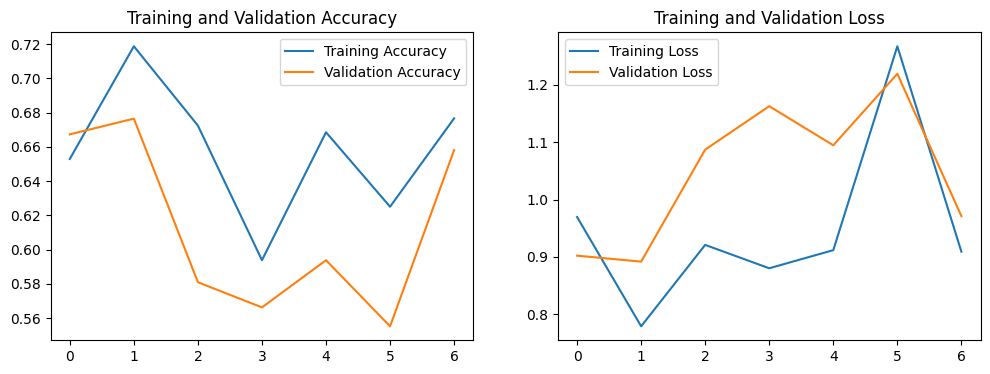

In [6]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

# Define callbacks
checkpoint_path = 'best_model.weights.h5'
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    mode='min',
    verbose=1,
    restore_best_weights=True
)

# 1. Train the new head layers
print("Training new classification layers...")
history_head = model.fit(
    train_generator,
    steps_per_epoch=len(train_df) // BATCH_SIZE,
    epochs=10,
    validation_data=val_generator,
    validation_steps=len(val_df) // BATCH_SIZE,
    callbacks=[early_stopping_callback, checkpoint_callback]
)

# 2. Fine-tune the entire model
print("\nFine-tuning the entire model...")
history_fine_tune = model.fit(
    train_generator,
    steps_per_epoch=len(train_df) // BATCH_SIZE,
    epochs=20, # More epochs for fine-tuning
    validation_data=val_generator,
    validation_steps=len(val_df) // BATCH_SIZE,
    callbacks=[early_stopping_callback, checkpoint_callback]
)

# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

plot_history(history_fine_tune)

In [7]:
import os
import pandas as pd
import numpy as np

# Load the best model weights
model.load_weights(checkpoint_path)

# Prepare test data for prediction
df_test = pd.read_csv(TEST_CSV)
df_test['id_code'] = df_test['id_code'].apply(lambda x: f'{x}.png')
# Use a dummy diagnosis column for the generator
df_test['diagnosis'] = '0' 

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_test,
    directory=TEST_DIR,
    x_col='id_code',
    y_col='diagnosis',
    target_size=IMG_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Make predictions
predictions = model.predict(test_generator, steps=len(df_test) // BATCH_SIZE + 1)
predicted_levels = np.argmax(predictions, axis=1)

# Create submission file
submission_df = pd.DataFrame({
    'id_code': df_test['id_code'].apply(lambda x: os.path.splitext(x)[0]),
    'diagnosis': predicted_levels
})

submission_df.to_csv('submission.csv', index=False)
print("Submission file 'submission.csv' created successfully.")
print(submission_df.head())

Found 1928 validated image filenames belonging to 1 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


61/61 ━━━━━━━━━━━━━━━━━━━━ 206s 3s/step
Submission file 'submission.csv' created successfully.
        id_code  diagnosis
0  0005cfc8afb6          2
1  003f0afdcd15          2
2  006efc72b638          2
3  00836aaacf06          2
4  009245722fa4          2


In [14]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
import numpy as np
import os
import matplotlib.pyplot as plt

# --- 1. Load the Model Architecture and Best Weights ---
# The model architecture must be identical to the one used for training.
# We'll use a simplified version for demonstration.
def build_model(img_size, n_classes):
    from tensorflow.keras.applications import ResNet50
    from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
    
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(img_size[0], img_size[1], 3)
    )
    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(n_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

IMG_SIZE = (224, 224)
N_CLASSES = 5
model = build_model(IMG_SIZE, N_CLASSES)

# Load the weights from the saved file.
# Make sure 'best_model.weights.h5' is in the current working directory.
model.load_weights('best_model.weights.h5')
print("Best model weights loaded successfully.")

# --- 2. Define the Prediction Function ---
def predict_severity(img_path):
    """
    Loads an image from a given path, preprocesses it, and predicts its severity level.
    """
    # Load and resize the image
    img = image.load_img(img_path, target_size=IMG_SIZE)
    # Convert the image to a numpy array and normalize pixel values
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0 # Normalize

    # Make the prediction
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)[0]
    confidence = np.max(prediction)
    
    # Map the class index to a meaningful label
    # This mapping must be the same as your training data.
    class_labels = {
        0: 'No DR',
        1: 'Mild',
        2: 'Moderate',
        3: 'Severe',
        4: 'Proliferative DR'
    }
    
    predicted_label = class_labels[predicted_class]

    # Display the image and results
    plt.imshow(img)
    plt.title(f'Predicted: {predicted_label} (Confidence: {confidence:.2f})')
    plt.axis('off')
    plt.show()

    return predicted_label, confidence

Best model weights loaded successfully.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


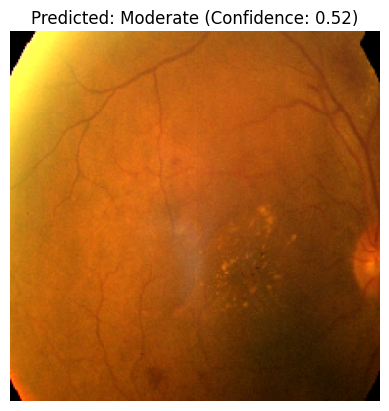


Final Prediction:
Severity Level: Moderate
Confidence: 0.52


In [13]:
# --- 3. Example Usage ---
# Replace 'path/to/your/image.png' with the actual path to the image you want to test.
# For a Kaggle notebook, you can upload an image and specify its path.
image_path = '/kaggle/input/aptos2019-blindness-detection/test_images/0005cfc8afb6.png'
predicted_label, confidence = predict_severity(image_path)

print(f"\nFinal Prediction:")
print(f"Severity Level: {predicted_label}")
print(f"Confidence: {confidence:.2f}")